<a href="https://colab.research.google.com/github/effieklestz/Chesapeake/blob/main/Underslab_Monthly_Revenue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install tensorflow

In [3]:
import requests
import json
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

In [18]:
username = 'Ephraim.klestzick@rossilabs.com'
password = 'Rj2^1!OJ@F%Q1CWs7!nA'
server_name = 'https://chesapeake.sisense.com/'

login_data =    {  'username' : username,
                        'password' : password
                    }

login_url = server_name + '/api/v1/authentication/login'
login_res = requests.post(url=login_url, data=login_data).json()

access_token = login_res.get('access_token')
if len(access_token) > 0:
    print('login succesful.')

api_header = {'Authorization': 'Bearer ' + access_token}

url = server_name + '/api/v1/users?'

urlSQL = server_name + '/api/datasources/ML_Project_new/sql?count=-1&includeMetadata=true&query=select%20%2A%20from%20UnderSlab_Revenue_predictions'

response = requests.get(urlSQL, headers=api_header)
if response.status_code == 404:
    print("Error: API endpoint not found.")

response_data = json.loads(response.text)

login succesful.


In [5]:
# df['Month'] = pd.to_datetime(df['Month'])
# last_month = df['Month'].max()
# future_months = last_month + pd.DateOffset(months=3)
# print(last_month)

In [19]:
# Functions
def min_max_scale(dataframe, target_column):
    mm = MinMaxScaler()
    features = dataframe.drop(columns=[target_column])
    scaled_features = mm.fit_transform(features)
    scaled_dataframe = pd.DataFrame(scaled_features, columns=features.columns)
    scaled_dataframe[target_column] = dataframe[target_column]
    return scaled_dataframe


def split_data(series, train_fraq, test_len=6):

    test_slice = len(series)-test_len

    test_data = series[test_slice:]
    train_val_data = series[:test_slice]
    train_size = int(len(train_val_data) * train_fraq)

    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]

    return train_data, val_data, test_data


def add_months_from_last(df, num_months):

    df['Month'] = pd.to_datetime(df['Month'])
    last_month = df['Month'].max()
    future_months = last_month + pd.DateOffset(months=num_months)

    return pd.date_range(start=last_month, periods=num_months, freq='MS')


def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
      for y_curr in y:
        plt.plot(x[start:end], y_curr[start:end], format)
    else:
      plt.plot(x[start:end], y[start:end], format)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
      plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_predictions2(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    y_actual = np.concatenate([batch_y.numpy() for _, batch_y in test_ds])
    df = pd.DataFrame(data={'Predictions': predictions, 'Actuals': y_actual})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    return df, mse(y_actual, predictions)

def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):

    window = n_steps

    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)

    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda x : (x[:, :-1], x[:, -1:]))
    ds = ds.batch(batch_size).prefetch(1)

    return ds

def df_to_X1_y1(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][-1]
    y.append(label)
  return np.array(X), np.array(y)

def plot_comparison(df, target_column, comparison_column ):

    plt.figure(figsize=(5, 3))
    plt.plot(df[target_column], color='blue', label=target_column)
    plt.ylabel(target_column)

    plt.twinx()
    plt.plot(df[comparison_column], color='red', label=comparison_column)
    plt.ylabel(comparison_column)
    plt.legend(loc='upper left')

    plt.show()

In [20]:
import pandas as pd
headers = response_data['headers']
values = response_data['values']

df = pd.DataFrame(values, columns=headers)
df.tail()

,Month,UnderslabRevenue,VolumeUnderslabSRevenuePct,CommercialUnderslabRevenue,Division1UnderslabRevenuePct,Division2UnderslabRevenuePct,Division3UnderslabRevenuePct,RyanUnderslabRevenuePct,LennarUnderslabRevenuePct,BlenheimUnderslabRevenuePct,...,BlenheimUnderslabRevenue,CommercialUnderslabRevenue1,Division1UnderslabRevenue,Division2UnderslabRevenue,Division3UnderslabRevenue,InsightUnderslabRevenue,LennarUnderslabRevenue,RyanUnderslabRevenue,SchellUnderslabRevenue,VolumeUnderslabSRevenue
47,2023-12,394082.17,87.8381,10.6759,9.7304,19.8936,18.5748,22.6726,21.1784,3.9836,...,15699.0,42071.94,38345.86,78397.30,73200.29,0.0,83460.55,89348.73,0.0,346154.63
48,2024-01,493694.29,79.9939,20.0060,10.6193,24.1646,15.6565,21.8761,18.8119,6.3163,...,31183.5,98768.66,52427.16,119299.32,77295.35,0.0,92873.65,108001.27,0.0,394925.63
49,2024-02,653239.74,79.9921,19.1934,4.9694,21.9250,16.2929,14.1865,13.6962,1.9949,...,13032.0,125379.00,32462.30,143223.45,106431.85,0.0,89469.06,92672.46,0.0,522540.74
50,2024-03,590656.81,70.9776,27.1141,8.3334,26.1296,11.8334,19.4062,15.4035,1.9793,...,11691.0,160151.47,49221.96,154336.80,69895.06,0.0,90981.94,114624.06,0.0,419234.34
51,2024-04,470736.11,83.2291,15.2838,17.0348,13.2785,14.1650,19.6630,13.5313,2.3070,...,10860.0,71946.65,80189.11,62506.74,66680.18,0.0,63696.74,92560.87,0.0,391789.46


In [22]:

df.drop(['Month'], axis=1,inplace=True)


In [23]:
# Scale and Split funtions
scaled_df = min_max_scale(df, 'UnderslabRevenue')
train_multi, val_multi, test_multi = split_data(scaled_df, train_fraq=0.80, test_len=6)

train_multi.astype("float32")
print("Multivarate Datasets")
print(f"Train Data Shape: {train_multi.shape}")
print(f"Val Data Shape: {val_multi.shape}")
print(f"Test Data Shape: {test_multi.shape}")
print(f"Nulls In Train {np.any(np.isnan(train_multi))}")
print(f"Nulls In Validation {np.any(np.isnan(val_multi))}")
print(f"Nulls In Test {np.any(np.isnan(test_multi))}")

Multivarate Datasets
Train Data Shape: (36, 52)
Val Data Shape: (10, 52)
Test Data Shape: (6, 52)
Nulls In Train False
Nulls In Validation False
Nulls In Test False


In [24]:
n_steps = 6
n_horizon = 3
batch_size = 1
shuffle_buffer = 5
expand_dims=False



def window_datasets(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):

    window = n_steps

    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)

    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda x : (x[:, :-1], x[-n_horizon:, -1:]))

    # ds = ds.map(lambda x: (x[:, :-1], tf.reshape(x[:, -1:], (-1, 2))))
    # ds = ds.map(lambda x: (x[:, :-1], tf.reshape(x[:, -n_horizon:], (-1, 1))))  # Adjust target labels
    # ds = ds.map(lambda x: (x[:, :-n_horizon], x[:, -n_horizon:])) <-- changes the number of targets from 1 to 2
    # ds = ds.map(lambda x : (x[:, :], x[:, -1:]))
    ds = ds.batch(batch_size).prefetch(1)

    return ds


train_ds = window_datasets(train_multi, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True,expand_dims=expand_dims)
val_ds = window_datasets(val_multi, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True, expand_dims=expand_dims)
test_ds = window_datasets(test_multi, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=True,expand_dims=expand_dims )

print('Example sample shapes')
for idx,(x,y) in enumerate(test_ds):
    print("x = ", x.numpy().shape)
    print("y = ", y.numpy().shape)
    break
print(test_ds)
for idx,(x,y) in enumerate(test_ds):

    print("y = ", y)

    break

Example sample shapes
x =  (1, 6, 51)
y =  (1, 3, 1)
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 51), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
y =  tf.Tensor(
[[[653239.74]
  [590656.81]
  [470736.11]]], shape=(1, 3, 1), dtype=float64)


In [25]:
def get_params():
    lr = 0.3
    n_steps=6
    n_horizon=3
    n_features=51
    return n_steps, n_horizon, n_features, lr

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}


def run_model(model_name, model_func, model_configs, epochs):

    n_steps, n_horizon, n_features, lr = get_params()


    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

In [26]:
def lstm_model(n_steps, n_horizon, n_features, lr):

    tf.keras.backend.clear_session()

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=(n_steps, n_features),kernel_regularizer=tf.keras.regularizers.l2(0.2)),


        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True,kernel_regularizer=tf.keras.regularizers.l2(0.1))),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu', return_sequences=False ,kernel_regularizer=tf.keras.regularizers.l2(0.1))),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')

    loss = tf.keras.losses.Huber()
    # optimizer = tf.keras.optimizers.Adam(learning _rate=lr)

    model.compile(loss=loss, optimizer='adam', metrics=['mae'],run_eagerly=True)

    return model



lstm = lstm_model(*get_params())
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             9856      
                                                                 
 bidirectional (Bidirection  (None, 6, 128)            66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320   

Epoch 1/100
11/11 [==============================] - 7s 622ms/step - loss: 382170.3125 - mae: 382119.1250 - val_loss: 439438.3125 - val_mae: 439393.6250
Epoch 2/100
11/11 [==============================] - 5s 479ms/step - loss: 382158.9688 - mae: 382119.0000 - val_loss: 439428.0625 - val_mae: 439393.4375
Epoch 3/100
11/11 [==============================] - 3s 258ms/step - loss: 382149.3125 - mae: 382118.4688 - val_loss: 439419.0000 - val_mae: 439392.3750
Epoch 4/100
11/11 [==============================] - 3s 247ms/step - loss: 382106.5000 - mae: 382082.5000 - val_loss: 438982.5625 - val_mae: 438960.9062
Epoch 5/100
11/11 [==============================] - 2s 199ms/step - loss: 369943.0312 - mae: 369922.0312 - val_loss: 386051.3438 - val_mae: 386030.7812
Epoch 6/100
11/11 [==============================] - 2s 199ms/step - loss: 165834.3438 - mae: 165813.7031 - val_loss: 93690.7031 - val_mae: 93670.3906
Epoch 7/100
11/11 [==============================] - 2s 197ms/step - loss: 118114.92

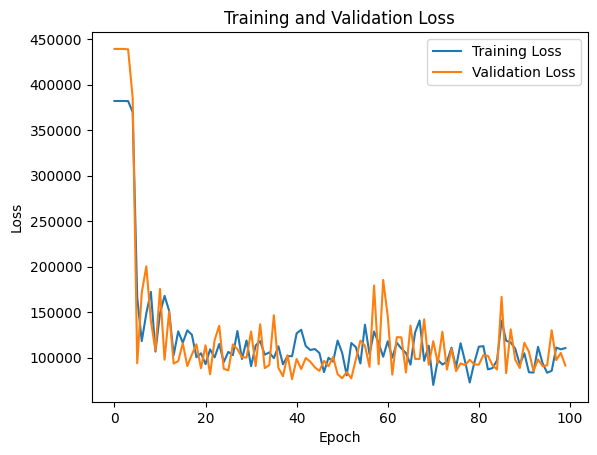

In [27]:
tf.keras.backend.clear_session()
history = lstm.fit(train_ds, validation_data=(val_ds), epochs=100)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [28]:
predictions = lstm.predict(test_ds).flatten()
df_result = pd.DataFrame(data={'Future Predictions':predictions})
df_result

1/1 [==============================] - 0s 166ms/step


,Future Predictions
0,513592.9375
1,529531.5000
2,567223.5625
